In [2]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.environment import Particle
from single_photons.utils.parameters import *

In [3]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
std_detection = 1
p = 0
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 0.178
delta_t = 1e-9
control_step = 30 
fs = 1/(control_step*delta_t)
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
env = Particle(omega, gamma, coupling, eta_detection=eta_detection)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
period = 2*np.pi/omega
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]


In [4]:
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])

In [5]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step

In [12]:
x0 = 0
P0 = 3e8*np.eye(2)
estimation = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
states = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
new_states = np.zeros((N, 2))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0, :] = estimation[:,0]
#estimation = estimation.reshape((2, 1))
control = np.array([[0]])
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[0, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((2))
        estimation = estimated_states[i, :].reshape((2, 1))
        control = np.array([[0]])
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    states = env.step(states, control=control, delta_t=delta_t)

  0%|          | 0/250693 [00:00<?, ?it/s]

100%|██████████| 250693/250693 [00:08<00:00, 31286.84it/s]


In [16]:
kalman.gainMatrices[0].shape
kalman.errors[0].shape

(1, 1)

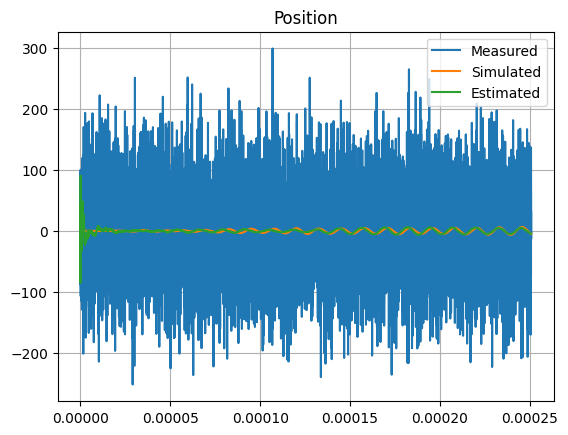

In [9]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states[:])
plt.plot(t, new_states[:,0])
plt.plot(t, estimated_states[:,0])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()

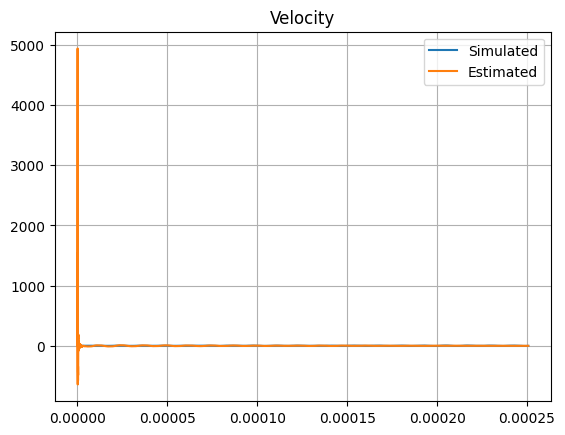

In [7]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], new_states[:,1])
plt.plot(t[:], estimated_states[:,1])
plt.grid()
plt.legend(['Simulated', 'Estimated'])
plt.show()

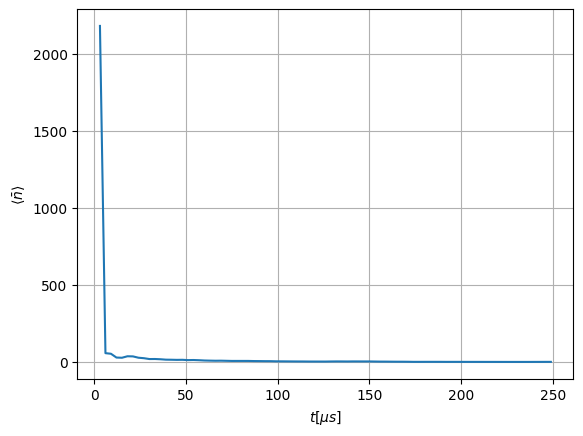

In [8]:
step=100
phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
plt.plot(t[::control_step][::step][1:]/1e-6, phonons)
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
plt.show()